# Klasifikace uměleckých děl

Název datasetu:<br>
<b>Best Artworks of All Time</b>

Popis:<br>
<b>Kolekce uměleckých děl od 50 nejznámějších malířů.</b>

Dataset dostupný z:<br>
https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time

In [2]:
import numpy as np
import pandas as pd

from fastai.vision.all import *
from fastai.data.all import *

import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import sampler, random_split
from torchvision import models

In [3]:
torchvision.__version__, torch.__version__ # ('0.14.0+cpu', '1.13.0+cpu')

('0.14.0+cpu', '1.13.0+cpu')

In [4]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

### Načtení dat

In [5]:
dataset_path = "./data/images/images/"
dls = ImageDataLoaders.from_folder(                      # podle podsložek se vytvori tridy
    dataset_path,   
    valid_pct=0.20,                                      # 80% testovych dat
    bs=32,                                               # velikost jednoho batche
    item_tfms=RandomResizedCrop(224, min_scale=0.4),     # vybere z orig. obrazku sektor (min. 40%) => zmensi
    shuffle=True)

classes = get_classes(dataset_path)
print("Tridy: ", classes[:10])
print("Velikost trenovacich dat: ", len(dls.train.dataset))
print("Velikost validacnich dat: ", len(dls.valid.dataset))
print("Celkem: " + str(len(dls.valid.dataset) + len(dls.train.dataset)))

Tridy:  ['Albrecht_Durer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez']
Velikost trenovacich dat:  2942
Velikost validacnich dat:  735
Celkem: 3677


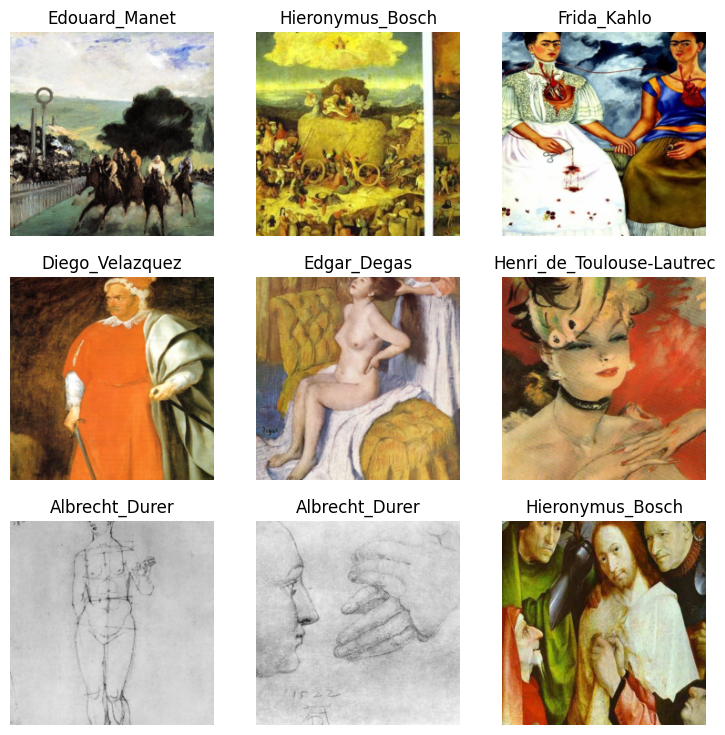

In [6]:
dls.show_batch()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model

In [10]:
# vyuziti predtrenovaneho modelu
#model = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)    # predpoklada obrazky 240 x 240 px
model = models.mobilenet_v2(pretrained=True)                                      # predpoklada obrazky 224 x 224 px

for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier[1].in_features

# nahrazení klasifikátoru
model.classifier = nn.Sequential(
    nn.Linear(in_features,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, len(classes))   # výstup je roven počtu tříd 
)

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=25, bias=True)
)


### Učení

In [11]:
# vytvoření instance pro učení
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate])
# learn.opt_func     # fastai.optimizer.Adam

In [273]:
learn.fit(7)

### Výsledky

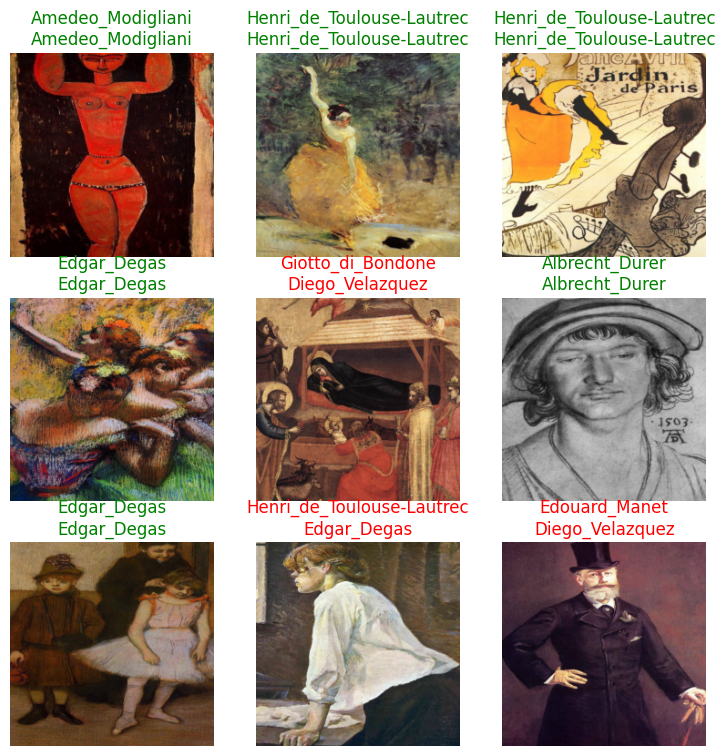

In [274]:
learn.show_results()

In [277]:
interp = ClassificationInterpretation.from_learner(learn)

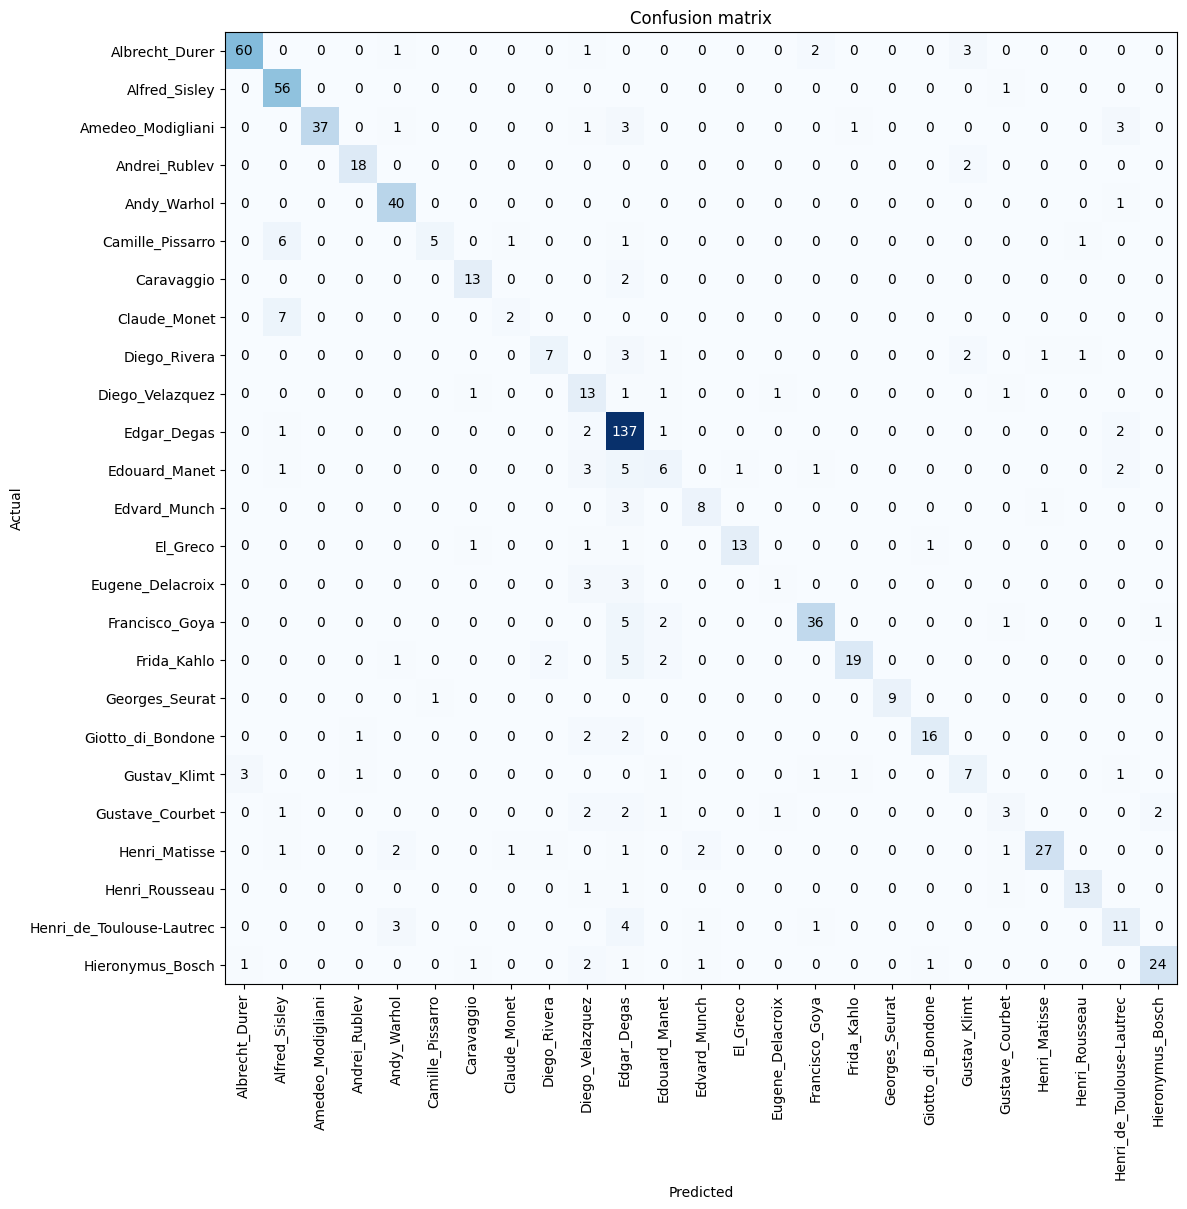

In [283]:
interp.plot_confusion_matrix(figsize=(12,12))  # absolutní hodnoty

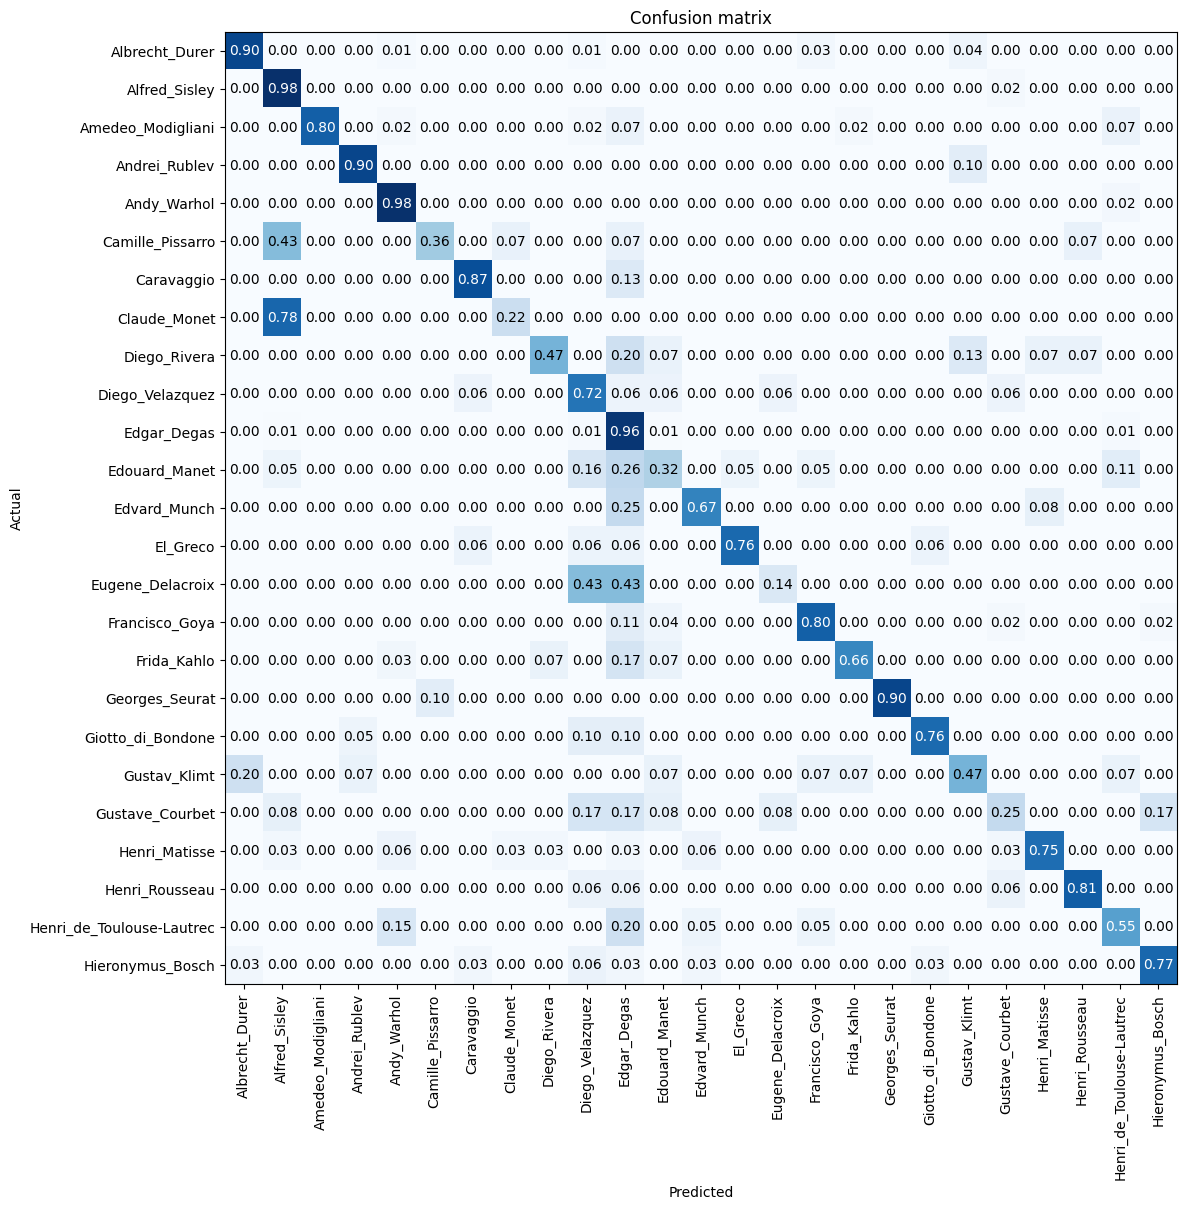

In [284]:
interp.plot_confusion_matrix(figsize=(12,12), normalize=True)   # normaliovane hodnoty

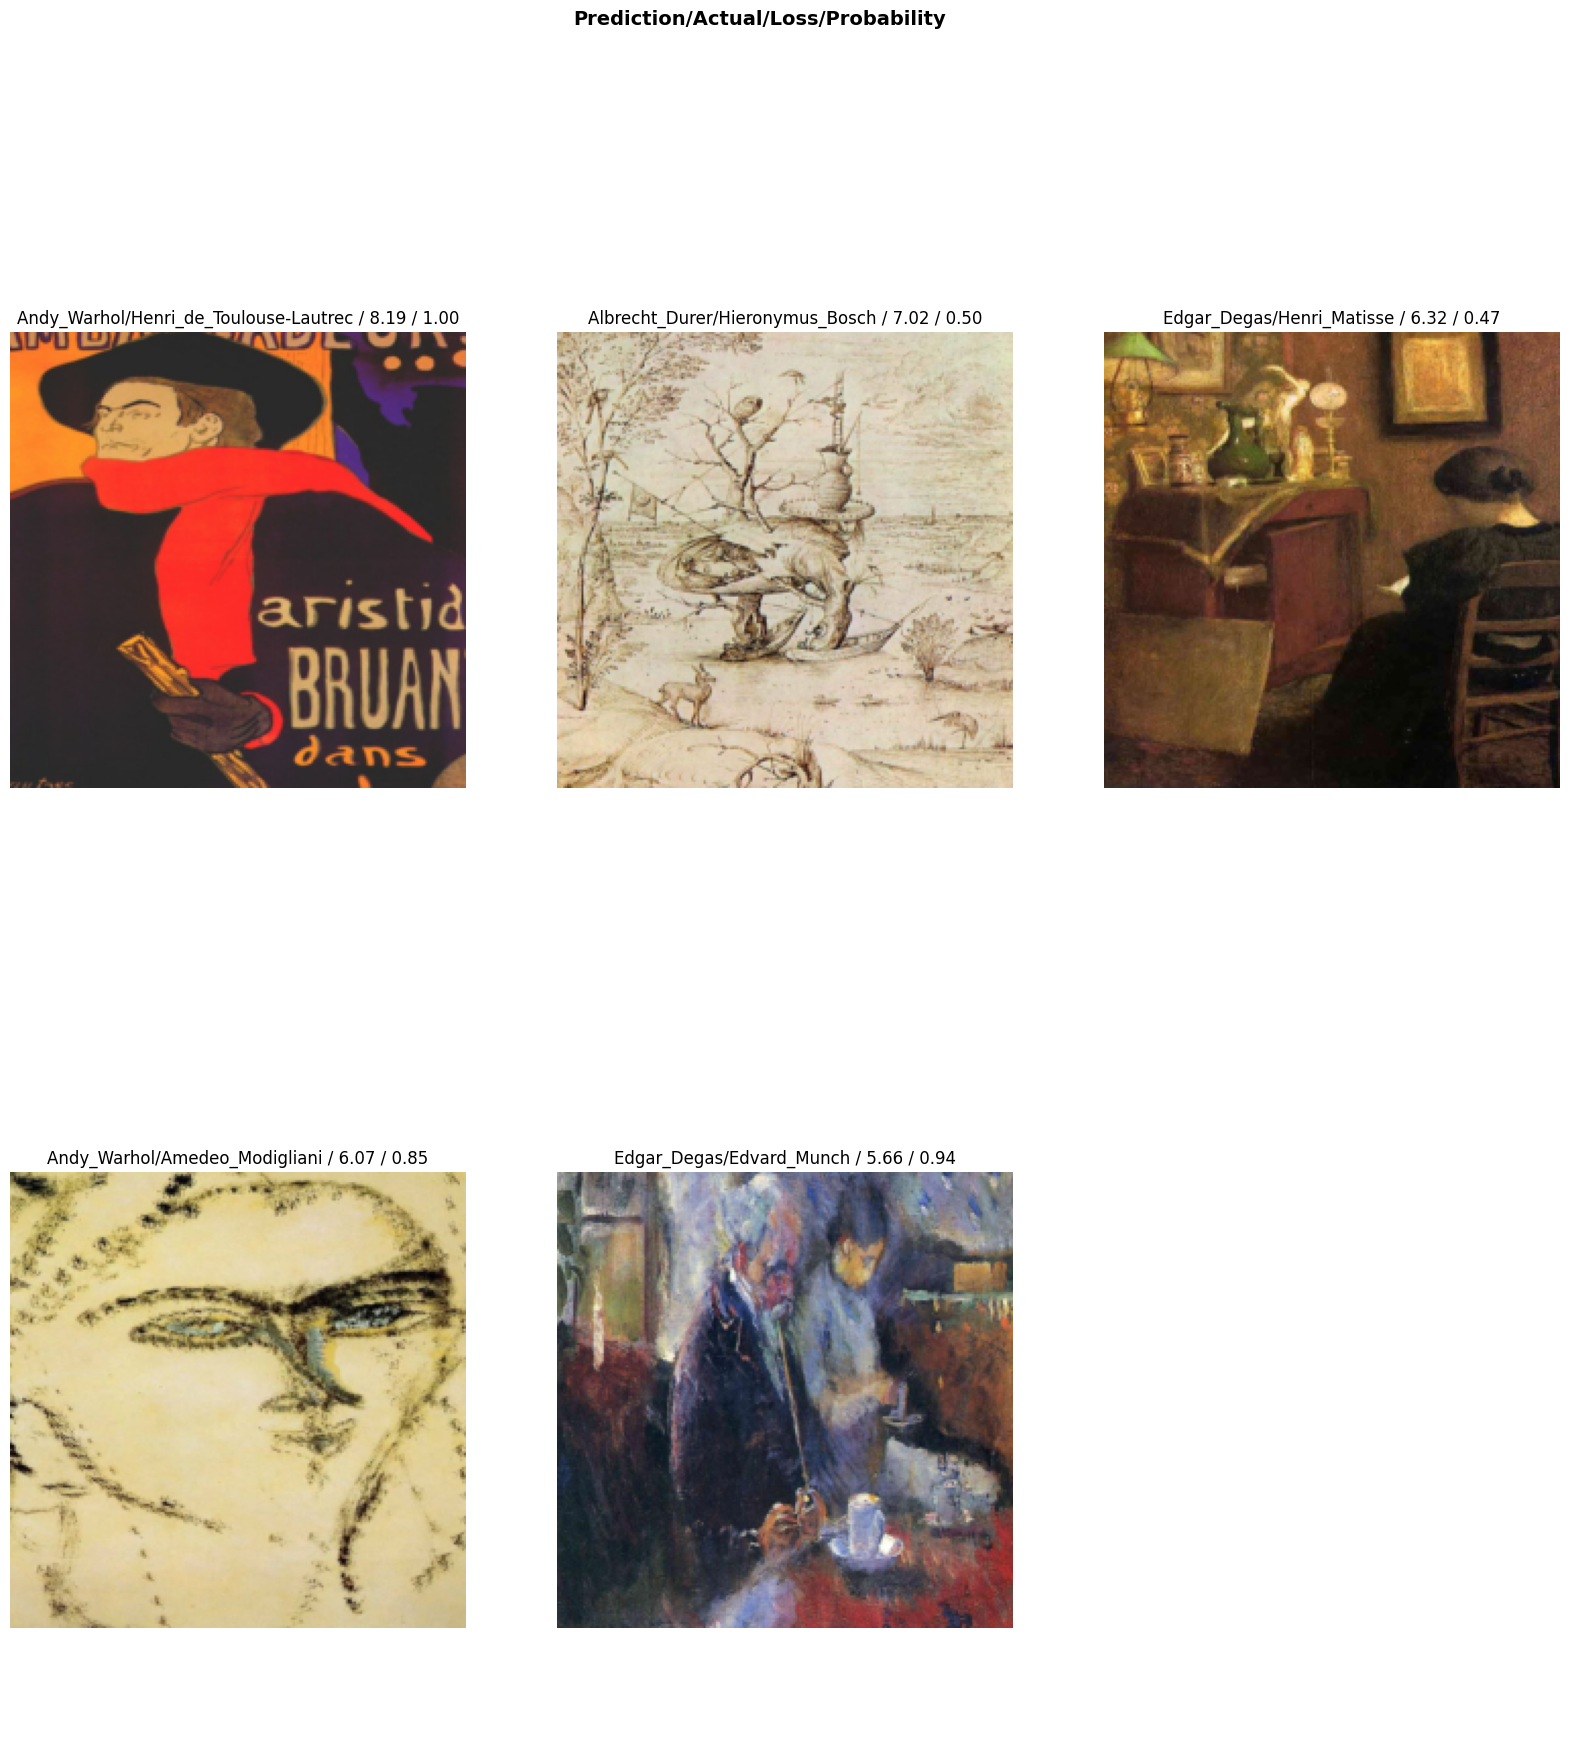

In [280]:
interp.plot_top_losses(5, figsize=(20, 20))